In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [28]:
df = pd.read_csv('bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [29]:
df = df.reindex(
    ['age', 'job', 'marital', 'education', 'balance',
     'housing', 'contact', 'day', 'month', 'duration',
     'campaign', 'pdays', 'previous', 'poutcome', 'y']
, axis=1)

df.y = df.y.map({'yes': 1, 'no': 0})

df_train_val, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_val, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

In [30]:
# Which numerical variable (among the following 4) has the highest AUC?
cols = ['balance', 'day', 'duration', 'previous']
for i in cols:
    score_ = roc_auc_score(df_train.y, df_train[i])
    if score_ < 0.5:
        score_ = roc_auc_score(df_train.y, -df_train[i])
    print(i, score_)

balance 0.5888313805382317
day 0.525957882383908
duration 0.8147002759670778
previous 0.5985653242764153


In [31]:
def x_y_split_and_index(df, y_column):
    df.reset_index(drop=True, inplace=True)
    cols_x = df.columns[df.columns!=y_column]
    X = df[cols_x].copy()
    y = df[y_column].values
    return X, y

X_train, y_train = x_y_split_and_index(df_train, 'y')
X_test, y_test = x_y_split_and_index(df_test, 'y')
X_val, y_val = x_y_split_and_index(df_val, 'y')
train_dicts = X_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(X_val.to_dict(orient='records'))

In [32]:
# What's the AUC of this model on the validation dataset? (round to 3 digits)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)

roc_auc_score(y_val, [i[1]>=0.5 for i in y_pred])

0.6528235214809679

c:\Users\49162\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


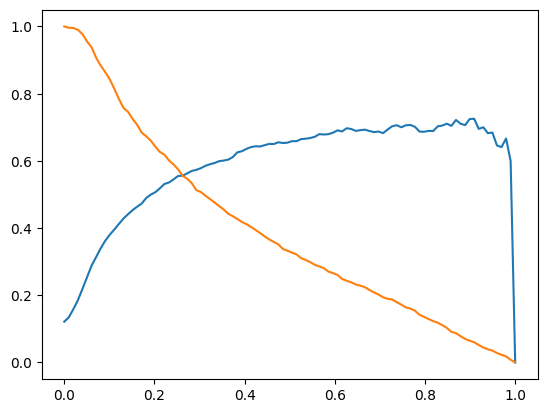

In [33]:
# At which threshold precision and recall curves intersect?
thresholds = np.linspace(0., 1., 100)
precisions = []
recalls = []
for t in thresholds:
    y_pred_ = [i[1]>=t for i in y_pred]
    precisions.append(precision_score(y_val, y_pred_))
    recalls.append(recall_score(y_val, y_pred_))

_ = plt.plot(thresholds, precisions)
_ = plt.plot(thresholds, recalls)

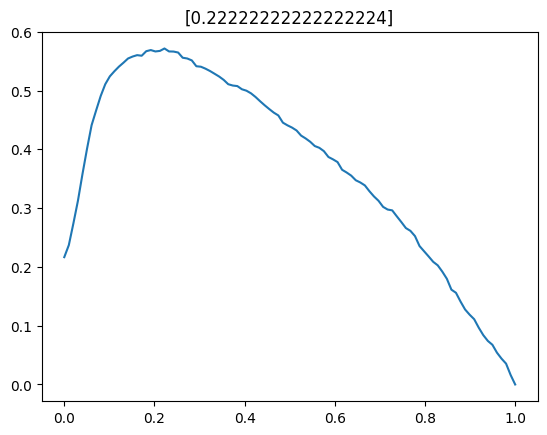

In [34]:
# At which threshold F1 is maximal?
results = {}
for t in thresholds:
    y_pred_ = [i[1]>=t for i in y_pred]
    f1 = f1_score(y_val, y_pred_)
    results[t] = f1

_ = plt.plot(results.keys(), results.values())
plt.title([k for k, v in results.items() if v==max(results.values())])
plt.show()

In [36]:
# How large is standard deviation of the scores across different folds?
def train_pipeline(df_train, y_column, C=1.):
    # split df
    X_train, y_train = x_y_split_and_index(df_train, y_column)
    # OHE
    train_dicts = X_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)
    # model fit
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

def predict_pipeline(df, y_column, dv_obj, model_obj):
    X, y = x_y_split_and_index(df, y_column)
    dicts = X.to_dict(orient='records')
    X = dv_obj.transform(dicts)
    y_pred = model_obj.predict_proba(X)[:, 1]

    return y, y_pred

scores_kfold = []
folds = KFold(n_splits=5, shuffle=True, random_state=1)
for train, val in folds.split(df_train_val):
    df_train = df_train_val.iloc[train]
    df_val = df_train_val.iloc[val]

    dv, model = train_pipeline(df_train, 'y', C=1.)
    y_val, y_pred = predict_pipeline(df_val, 'y', dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores_kfold.append(auc)
np.std(scores_kfold)

0.005691215739889739

In [40]:
# Which C leads to the best mean score?
results = {}

for c in [0.000001, 0.001, 1]:
    folds = KFold(n_splits=5, shuffle=True, random_state=1)
    scores_kfold_c = []
    for train, val in folds.split(df_train_val):
        df_train = df_train_val.iloc[train]
        df_val = df_train_val.iloc[val]

        dv, model = train_pipeline(df_train, 'y', C=c)
        y_val, y_pred = predict_pipeline(df_val, 'y', dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores_kfold_c.append(auc)
    results[c] = scores_kfold
k_fold_c_res = pd.DataFrame.from_dict(results)
k_fold_c_res.agg(['mean', 'std'])

,0.000001,0.001000,1.000000
mean,0.905944,0.905944,0.905944
std,0.006363,0.006363,0.006363
